http://intomath.org/wp-content/uploads/2021/03/Fx-ab-c.jpg

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
!pip install wandb
import wandb
!wandb login
import os
import seaborn as sns
import plotly.express as px
import math as m
from scipy.stats import norm
euler = m.e
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
torch.manual_seed(13)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.6 MB/s 
     |████████████████████████████████| 181 kB 47.2 MB/s 
     |████████████████████████████████| 145 kB 47.9 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=c35994aa4714cae9e9be83dea6dbf12b63db889f9acd4a7f04d1500502bea6f3
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
class DL:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

In [ ]:
def gen_data(A=True, B=True, C=True, D=True, size=10000):
  if A==True: 
    a = np.concatenate((np.random.uniform(low=-3, high=0, size=int(size/2)).tolist(), np.random.uniform(low=0, high=3, size=int(size/2))), axis=0)
    np.random.shuffle(a)
  else:
    a = np.full(shape=size, fill_value=1,dtype=float)
  if B==True: 
    b = np.random.uniform(low=1/(euler), high=(euler), size=int(size))
    np.random.shuffle(b)
  else:
    b = np.full(shape=size, fill_value=euler,dtype=float)
  if C==True: 
    c = np.random.uniform(low=-3, high=3, size=size).tolist()
  else:
    c = np.full(shape=size, fill_value=0,dtype=float)
  if D==True: 
    d = np.random.uniform(low=-euler, high=euler, size=size)
  else:
    d = np.full(shape=size, fill_value=0,dtype=float)
  mlist = []
  for i, t in enumerate(a):
    mlist.append([a[i]*(b[i]**(x-d[i]))+c[i] for x in np.arange(-euler,euler,euler/50)])
  data = pd.DataFrame(mlist)

  data['a'] = a
  data['b'] = b
  data['c'] = c
  data['d'] = d
  return data

def norm(t):
  # return (t-torch.mean(t))/torch.std(t)
  return (t-torch.min(t))/(torch.max(t)-torch.min(t))

def plot_data(data):
  x1 = [x for x in np.arange(-euler, euler, euler/50)]
  for index, row in data.drop(columns=['a', 'b', 'c', 'd']).iterrows():
    plt.plot(x1, row) 
  plt.ylim(-10, 10)
  plt.xlim(-euler, euler-euler/50)

def split_data(data): 
  msk = np.random.rand(len(data)) < 0.8
  train = data[msk]
  test = data[~msk]
  msk2 = np.random.rand(len(test)) < 0.8
  validate = test[~msk2]
  test = test[msk2]

  train_data = torch.tensor(train.values, requires_grad=True, dtype=torch.float32)
  test_data = torch.tensor(test.values, requires_grad=True, dtype=torch.float32)
  validate_data = torch.tensor(validate.values, requires_grad=True, dtype=torch.float32)

  trains = {
  'X': norm(train_data[:, :100]),
  'A': norm(train_data[:, 100:101].unsqueeze(dim=1)),
  'B': norm(train_data[:, 101:102].unsqueeze(dim=1)),
  'C': norm(train_data[:, 102:103].unsqueeze(dim=1)),
  'D': norm(train_data[:, 103:].unsqueeze(dim=1))
  }

  tests = {
  'X': norm(test_data[:, :100]),
  'A': norm(test_data[:, 100:101].unsqueeze(dim=1)),
  'B': norm(test_data[:, 101:102].unsqueeze(dim=1)),
  'C': norm(test_data[:, 102:103].unsqueeze(dim=1)),
  'D': norm(test_data[:, 103:].unsqueeze(dim=1))
  }

  X_val = validate_data[:, :100].mul(0.1)
  Exp_val = validate_data[:, 100:101].unsqueeze(dim=1)
  Coef_val = validate_data[:, 101:].unsqueeze(dim=1)
  return trains, tests

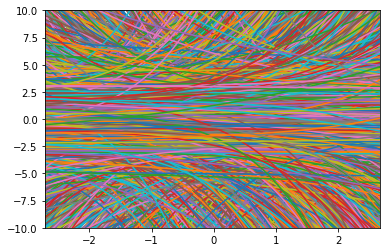

In [ ]:
data = gen_data(A=True, B=True, C=True, D=True)
trains, tests = split_data(data)
plot_data(data)

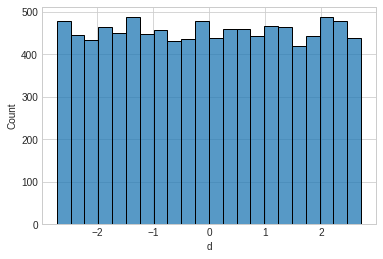

In [ ]:
sns.histplot(data=data, x='d')

In [ ]:
# class Calico(torch.nn.Module):
#   def __init__(self, latent_dim, ae_layer, branch_layer, end_dim):
#     super().__init__()
#     self.encoder = torch.nn.Sequential(
#         torch.nn.Linear(100, ae_layer),
#         torch.nn.ReLU(),
#         torch.nn.Linear(ae_layer, latent_dim)
#     )
#     self.decoder = torch.nn.Sequential(
#         torch.nn.ReLU(),
#         torch.nn.Linear(latent_dim, ae_layer),
#         torch.nn.ReLU(),
#         torch.nn.Linear(ae_layer, 100),
#         torch.nn.Sigmoid()
#     )
#     self.branch = torch.nn.Sequential(
#         torch.nn.ReLU(),
#         torch.nn.Linear(latent_dim, branch_layer),
#         torch.nn.ReLU(),
#         torch.nn.Linear(branch_layer, end_dim),
#         torch.nn.Sigmoid()
#     )

#   def reparameterize(self, mu, log_var):
#     std = torch.exp(0.5*log_var)
#     eps = torch.randn_like(std)
#     sample = mu + (eps * std)
#     return sample

#   def forward(self, x):
#     ls = self.encoder(x)#.unsqueeze(dim=2)

#     mu = ls[:, 0] 
#     log_var = ls[:, 1]

#     ls = self.reparameterize(mu, log_var)
#     return ls, self.decoder(ls), self.branch(ls)

In [ ]:
class Calico(torch.nn.Module):
    def __init__(self, latent_dim, ae_layer, branch_layer, end_dim):
        super().__init__()
 
        self.enc1 = torch.nn.Linear(in_features=100, out_features=ae_layer)
        self.enc2 = torch.nn.Linear(in_features=ae_layer, out_features=latent_dim*2)
 
        self.dec1 = torch.nn.Linear(in_features=latent_dim, out_features=ae_layer)
        self.dec2 = torch.nn.Linear(in_features=ae_layer, out_features=100)
        self.latent_dim = latent_dim

        self.branch1 = torch.nn.Linear(in_features=latent_dim, out_features=branch_layer)
        self.branch2 = torch.nn.Linear(in_features=branch_layer, out_features=end_dim)

    def reparameterize(self, mu, sigma):
        std = torch.exp(sigma/2)
        epsilon = torch.randn_like(std)
        sample = mu + (epsilon * std) 
        return sample
 
    def forward(self, x):
        x = torch.nn.functional.relu(self.enc1(x))
        x = self.enc2(x)
        x = x.view(-1, 2, self.latent_dim)

        mu = x[:, 0, :] # mean
        sigma = x[:, 1, :] # variance

        ls = self.reparameterize(mu, sigma)
 
        # decoding
        x = torch.nn.functional.relu(self.dec1(ls))
        reconstruction = torch.sigmoid(self.dec2(x))
        
        #branch
        preds = torch.nn.functional.relu(self.branch1(ls))
        preds = torch.sigmoid(self.branch2(preds))

        return ls, reconstruction, preds, mu, sigma

In [ ]:
class Abyssinian:
  def __init__(self, dicty):
    self.dicty = dicty
    self.model = Calico(dicty['latent_dim'], dicty['ae_layer'], dicty['branch_layer'], dicty['num_vars'])

  def kl(self, p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

  def train(self, x, a, var):
    self.var = var
    wandb.log({'vars': var})
    optimizer = torch.optim.Adam(self.model.parameters(), lr=self.dicty['learning_rate'])
    train_batches = DL(x, a, batch_size=self.dicty['batch_size'], shuffle=False)
    wandb.log(self.dicty)
    for epoch in range(self.dicty['epochs']):
      for idx, batch in enumerate(train_batches):
        optimizer.zero_grad()
        ls, recon, pred, mu, sigma = self.model(batch[0])
        recon_loss = torch.nn.MSELoss()(recon, batch[0])
        branch_loss = torch.nn.MSELoss()(pred.squeeze(), batch[1].squeeze())
        kl = torch.nn.KLDivLoss(reduction='sum')(torch.nn.functional.log_softmax(pred.squeeze(), -1), batch[1].squeeze())#self.kl(mu, sigma)
        loss = recon_loss + self.dicty['branch_weight']*branch_loss + self.dicty['kl_weight']*kl
        loss.backward(retain_graph=True)
        optimizer.step()
        wandb.log({'loss': loss, 'recon_loss': recon_loss, 'branch_loss': branch_loss, 'kl': kl})

  def save(self):
    self.file_path = 'model_' + self.var + '_' + self.dicty['latent_dim']
    torch.save(self.model.state_dict(), self.file_path)

  def test_model(self):
    weights = torch.load(self.file_path)
    self.model.load_state_dict(weights)
    self.model.eval()

In [ ]:
wandb.init(project="exponentials", entity="sophied")
cat = Abyssinian({'latent_dim': 5, 'ae_layer': 15, 'branch_layer': 30, 'learning_rate': .0028, 'batch_size': 64, 'epochs': 3000, 'num_vars': 3, 'branch_weight': 85, 'kl_weight': .03})
cat.train(trains['X'], torch.cat((trains['B'], trains['C'], trains['D']), axis=1), 'A+B+C+D')

ae_layer,▁
batch_size,▁
branch_layer,▁
branch_loss,██▇▅▅▅▅▄▃▅▃▃▅▄▄▄▃▃▄▃▂▆▄▁▄▄▃▃▃▂▂▃▂▂▃▂▃▁▁▃
branch_weight,▁
epochs,▁
kl,▅█▇▅▅▆▅▅▅▇▆█▄▃▄▃▅▅▃▂▅▇▁▅▅▄▆▆▇▅▅▅▆▅▇▆▆▄▃▇
kl_weight,▁
latent_dim,▁
learning_rate,▁
loss,▇█▆▄▅▅▅▄▃▅▃▄▄▄▄▄▃▃▃▂▂▆▃▂▄▄▃▃▃▂▂▃▂▂▄▃▃▁▁▄


KeyboardInterrupt: ignored

In [ ]:
torch.save(cat.model.state_dict(), 'model_BCD_5.zip')

In [ ]:
class Test:
  def __init__(self):
    self.model = Calico(10, 15, 30, 4)

  def test_model(self, x, a):
    weights = torch.load('model_ABCD_10.zip')
    self.model.load_state_dict(weights)
    self.model.eval()
    self.ls, self.recon, self.pred, mu, sigma = self.model(x)
    self.x_test = x
    loss = torch.nn.MSELoss()(self.recon, x) + torch.nn.MSELoss()(self.pred.squeeze(), a.squeeze())# + torch.nn.KLDivLoss(reduction='sum')(torch.nn.functional.log_softmax(self.pred.squeeze(), -1), x.squeeze())
  
  def loss_hist(self):
    losses = []
    dataloader = DL(self.recon, self.x_test, batch_size=1, shuffle=False)
    for idx, row in enumerate(dataloader):
      losses.append(self.loss_func(row))
    fig, ax = plt.subplots()
    sns.histplot(data=losses, ax=ax, binwidth=.000003)
    self.losses = losses
    ax.set_xlim(0, .0001)
    plt.show()

  def graph_correlation(self, t, var, width=.03):
    plt.style.use('seaborn-whitegrid')
    if var == 'a':
      dt = t['A'].add(-0.5).mul(6)
      pred = self.pred[:, :1].add(-0.5).mul(6)
      # plt.xlim(-3, 3)
      # plt.ylim(-3, 3)
    elif var == 'b':
      dt = t['B'].mul(euler)
      pred = self.pred[:, 0:1].mul(euler)
      print(dt.shape, pred.shape)
      # plt.xlim(0, euler)
      # plt.ylim(0, euler)
    elif var == 'c':
      dt = t['C'].add(-.5).mul(2)
      pred = self.pred[:, 1:2].add(-.5).mul(2)
      # plt.xlim(-1, 1)
      # plt.ylim(-1, 1)
    elif var == 'd':
      dt = t['D'].add(-.5).mul(6)
      pred = self.pred[:, 2:3].add(-.5).mul(6)
      # plt.xlim(-3, 3)
      # plt.ylim(-3, 3)
    plt.plot(dt.detach().numpy().reshape(-1,), dt.detach().numpy().reshape(-1,), color='gray', linewidth=0.1)
    plt.scatter(pred.detach().numpy().reshape(-1,), dt.detach().numpy().reshape(-1,), color='purple', s=width)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(var + '-value')

  def graph_recon(self, sam):
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(1, 1)
    x = [x for x in np.arange(-euler, euler, euler/50)]
    print(x, self.recon)
    colors = ['mistyrose', '#ccffb3', '#ADD8E6']
    a = 0
    for i in sam:
      plt.plot(x, self.x_test.detach().numpy().tolist()[i], color=colors[a], linewidth=5)
      a+=1
    # plt.xlabel('time')
    # plt.ylabel('sample remaining')
    colors = ['salmon', 'darkolivegreen', 'darkcyan']
    a = 0
    for i in sam:
      plt.plot(x, self.recon.detach().numpy().tolist()[i], '--', color=colors[a], linewidth=1)
      a+=1
    fig.set_size_inches(12, 8)
    plt.ylim(-1, 1)
    plt.xlim(-euler, euler-euler/50)
    plt.show()

  def graph_latent_space(self, t, latent_dim, num_branches):
    dims = []
    for dim in range(latent_dim):
      dims.append([i[dim] for i in self.ls.detach().numpy()])

    if num_branches == 1:
      if latent_dim==1:
        fig, axs = plt.subplots(1, 1)
        axs.scatter(t['B'].detach().numpy(), dims[0], s=0.1, color='blue')
        axs.set(xlabel='a-value', ylabel='latent_space')
      else:
        fig, axs = plt.subplots(1, latent_dim)
        for dim in range(latent_dim):
          axs[dim].scatter(t['D'].detach().numpy(), dims[dim], s=0.1, color='blue')
          axs[dim].set(xlabel='d-value', ylabel='latent_space')
    else:
      fig, axs = plt.subplots(num_branches, latent_dim)
      for dim in range(latent_dim):
        for bra in range(num_branches):
          axs[dim, bra].scatter(list(t.values())[bra+1].detach().numpy(), dims[dim], s=0.1, color='purple')
          axs[dim, bra].set(xlabel=str(dim) + 'value', ylabel='latent_space')
    fig.set_size_inches(latent_dim*5, num_branches*5)
    plt.style.use('seaborn-whitegrid')

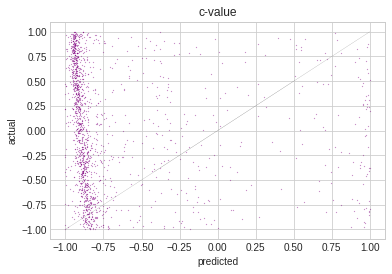

In [ ]:
may = Test()
may.test_model(tests['X'], torch.cat((tests['A'], tests['B'], tests['C'], tests['D']), axis=1))
may.graph_correlation(tests, 'c')